# Working with time series, frequency series, and unit conversion

In this notebook, we show some of the most useful features of the [timeseries](../series.rst) module. To do so, we will analyze a fake gravitational-wave signal. We will also show the [frequencyseries](../series.rst) module and the [unitconv](../unitconv.rst) modules.

First, let's generate this signal. 

(This notebook is meant to be converted in Sphinx documentation and not used directly.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from kuibit import timeseries as ts
from kuibit import series
from kuibit import unitconv as uc
from kuibit.gw_utils import luminosity_distance_to_redshift

%matplotlib inline

In [2]:
t = np.linspace(0, 20, 5000)
y = np.sin(t)

# Generate a TimeSeries by providing the times and the values of the series
gw = ts.TimeSeries(t, y)

To access the times and the values, use ``gw.t`` and ``gw.y``. You can also iterate over the series with a for loop yielding the elements `(t, y)` at each iteration of the loop. For example.

In [3]:
for tt, yy in gw:
    print(tt, yy)

0.0 0.0
0.004000800160032006 0.004000789486971321
0.008001600320064013 0.008001514935783532
0.012002400480096018 0.012002112309302542
0.016003200640128026 0.016002517572444287
0.020004000800160033 0.020002666693199687
0.024004800960192037 0.024002495643659576
0.028005601120224044 0.028001940401039562
0.03200640128025605 0.03200093694870479
0.03600720144028806 0.03599942127719461
0.040008001600320066 0.03999732938524717
0.04400880176035207 0.0439945972808238
0.048009601920384073 0.04799116098213332
0.05201040208041608 0.05198695651865616
0.05601120224044809 0.055981919932168285
0.060012002400480095 0.059975987277764924
0.0640128025605121 0.06396909462488413
0.0680136027205441 0.06796117805833003
0.07201440288057612 0.07195217367929596
0.07601520304060812 0.07594201760638712
0.08001600320064013 0.07993064597664322
0.08401680336067213 0.08391799494656059
0.08801760352070415 0.08790400069311417
0.09201840368073615 0.09188859941477902
0.09601920384076815 0.09587172733255157
0.10002000400080

3.652730546109222 -0.4891700200694558
3.656731346269254 -0.49265554752817603
3.660732146429286 -0.4961331893547125
3.664732946589318 -0.49960288988460666
3.66873374674935 -0.5030645935805115
3.672734546909382 -0.5065182450330801
3.676735347069414 -0.5099637889618529
3.680736147229446 -0.5134011702161426
3.684736947389478 -0.5168303337759168
3.68873774754951 -0.5202512247526784
3.692738547709542 -0.5236637883903444
3.696739347869574 -0.5270679700661227
3.700740148029606 -0.5304637152913859
3.704740948189638 -0.5338509697125434
3.70874174834967 -0.537229679111912
3.712742548509702 -0.5405997894085832
3.716743348669734 -0.5439612466592889
3.720744148829766 -0.5473139970592653
3.724744948989798 -0.5506579869431133
3.72874574914983 -0.5539931627856585
3.732746549309862 -0.5573194712028067
3.736747349469894 -0.5606368589523998
3.740748149629926 -0.5639452729350668
3.744748949789958 -0.5672446601950746
3.74874974994999 -0.5705349679211749
3.7527505501100222 -0.57381614344745
3.756751350270054

7.545509101820364 0.9527984259906559
7.549509901980396 0.954005454743564
7.553510702140428 0.9551972133220976
7.55751150230046 0.9563736826505151
7.561512302460492 0.9575348438978011
7.565513102620524 0.9586806784779663
7.569513902780556 0.9598111680503467
7.573514702940588 0.9609262945198958
7.57751550310062 0.9620260400374749
7.581516303260652 0.963110387000139
7.585517103420684 0.9641793180514175
7.589517903580716 0.9652328160815936
7.593518703740748 0.9662708642279768
7.59751950390078 0.9672934458751732
7.601520304060812 0.968300544655352
7.605521104220844 0.9692921444485068
7.609521904380876 0.970268229382714
7.613522704540908 0.9712287838343865
7.61752350470094 0.9721737924285243
7.621524304860972 0.9731032400389602
7.625525105021004 0.9740171117886021
7.629525905181036 0.9749153930496708
7.633526705341068 0.9757980694439348
7.6375275055011 0.9766651268429396
7.641528305661132 0.9775165513682347
7.645529105821164 0.9783523293915949
7.649529905981196 0.9791724475352392
7.653530706

-0.9667293617415073
11.258251650330067 -0.9656982173886438
11.262252450490099 -0.964651615702597
11.26625325065013 -0.9635895734356718
11.270254050810163 -0.9625121075873206
11.274254850970195 -0.9614192354038722
11.278255651130227 -0.9603109743782544
11.282256451290259 -0.9591873422497151
11.28625725145029 -0.9580483570035376
11.290258051610323 -0.9568940368707535
11.294258851770355 -0.9557244003278498
11.298259651930387 -0.9545394660964744
11.302260452090419 -0.9533392531431355
11.30626125225045 -0.9521237806788982
11.310262052410483 -0.9508930681590777
11.314262852570515 -0.9496471352829267
11.318263652730547 -0.9483860019933209
11.322264452890579 -0.94710968847644
11.326265253050611 -0.9458182151614436
11.330266053210643 -0.9445116027201452
11.334266853370675 -0.9431898720666808
11.338267653530707 -0.9418530443571742
11.342268453690739 -0.9405011409893985
11.346269253850771 -0.9391341836024335
11.350270054010803 -0.9377521940763194
11.354270854170835 -0.9363551945317065
11.35827165

14.950990198039609 0.686724264477192
14.95499099819964 0.6838105225838296
14.958991798359673 0.6808858353590048
14.962992598519705 0.6779502496163744
14.966993398679737 0.6750038123440412
14.970994198839769 0.6720465707038011
14.9749949989998 0.6690785720303897
14.978995799159833 0.666099863830723
14.982996599319865 0.6631104937831381
14.986997399479897 0.6601105097366297
14.990998199639929 0.6570999597100841
14.99499899979996 0.6540788918915108
14.998999799959993 0.6510473546372709
15.003000600120025 0.6480053964713037
15.007001400280057 0.644953066084349
15.011002200440089 0.6418904123331687
15.015003000600121 0.6388174842397643
15.019003800760153 0.6357343309905922
15.023004600920183 0.6326410019357782
15.027005401080215 0.6295375465883216
15.031006201240247 0.6264240146233112
15.03500700140028 0.6233004558771245
15.039007801560311 0.6201669203466313
15.043008601720343 0.6170234581883942
15.047009401880375 0.6138701197178646
15.051010202040407 0.6107069554085782
15.05501100220044 0.

18.691738347669535 -0.15716327828947113
18.695739147829567 -0.15321095027714682
18.6997399479896 -0.14925616991204488
18.70374074814963 -0.1452990004958849
18.707741548309663 -0.1413395053686265
18.711742348469695 -0.1373777479074556
18.715743148629727 -0.13341379152576982
18.71974394878976 -0.12944769967216357
18.72374474894979 -0.12547953582941243
18.727745549109823 -0.12150936351345708
18.731746349269855 -0.11753724627238647
18.735747149429887 -0.11356324768542088
18.73974794958992 -0.10958743136189406
18.74374874974995 -0.10560986094023514
18.747749549909983 -0.10163060008695006
18.751750350070015 -0.09764971249560243
18.755751150230047 -0.09366726188579402
18.75975195039008 -0.08968331200214492
18.76375275055011 -0.08569792661327312
18.767753550710143 -0.08171116951077387
18.771754350870175 -0.07772310450819861
18.775755151030207 -0.0737337954400335
18.77975595119024 -0.0697433061606777
18.78375675135027 -0.06575170054342126
18.787757551510303 -0.06175904247942281
18.7917583516703

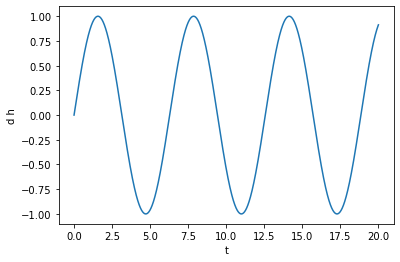

In [4]:
def plot(ser, lab1="d h", lab2="t", *args, **kwargs):
    """Plot Series ser with labels"""
    plt.ylabel(lab1)
    plt.xlabel(lab2)
    plt.plot(ser, *args, **kwargs)
    
plot(gw)

Let's make this more interesting: we square the signal and add Gaussian noise. [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) support directly using all the basic mathematical operations in Python and NumPy, so we can easily square the signal and add another TimeSeries to it.

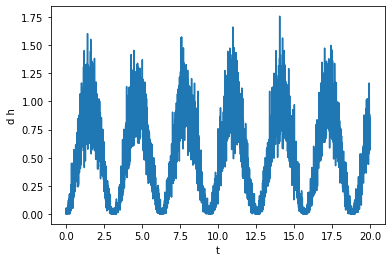

In [5]:
noise = np.random.normal(0, 0.1, len(gw))  # Here we used len() on the TimeSeries
noise_ts = ts.TimeSeries(t, noise)

gw += noise_ts
gw **= 2

plot(gw)

To analyze this signal, first we will smooth it. To do that, we will use the [savgol_smooth_time](../timeseries_ref.html#kuibit.timeseries.TimeSeries.savgol_smooth_time) method, which is a generalized "running average" filter. This method requires length of time over which we want to smooth the data.

In [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) there are always two different methods to do the same task, one with imperative verb (e.g., smooth), and the other with the past tense (e.g., smoothed). The first modifies the data, the second returns a new `TimeSeries` with the operation applied. Here, we will find what smoothing length to use by trial and error, so we will use the second method. 

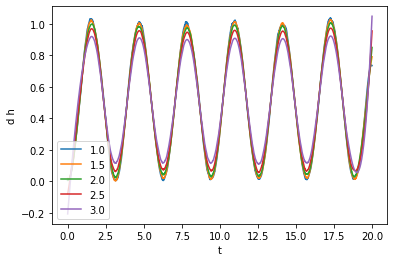

In [6]:
tsmooth = np.linspace(1, 3, 5)

for tsm in tsmooth:
    smoothed = gw.savgol_smoothed_time(tsm)
    plot(smoothed, label=tsm)
plt.legend()

From visual inspection it looks like that ``tsmooth = 1.5`` will work yield a clean series faithful to the original one.

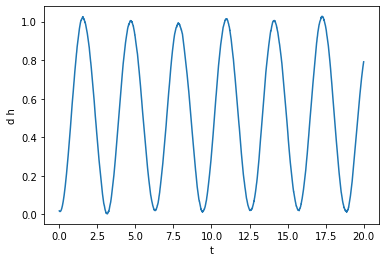

In [7]:
gw.savgol_smooth_time(1.5)
plot(gw)

Next, for fun, we can compute integrals and derivatives. For instance, we can compute what is the integral from 5 to 10.

The integral from 5 to 10 is 2.1928


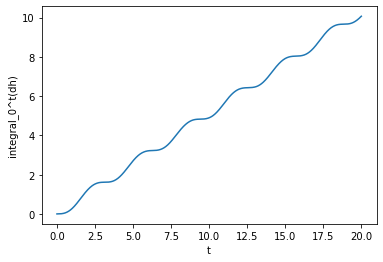

In [8]:
gw_int = gw.integrated()
a = 5
b = 10
print(f"The integral from {a} to {b} is {gw_int(b) - gw_int(a):.4f}")
plot(gw_int, lab1="integral_0^t(dh)")

Here, we showed a very powerful feature of `TimeSeries`: you can call them on a specific time (as we did we ``gw_int(b)``). This is done using splines to interpolate to the points that are not available. Splines can also be used to take derivatives. Alternatively, one can simply take the finite (central) difference. Let's see what's the derivative of ``gw`` using splines and finite difference.

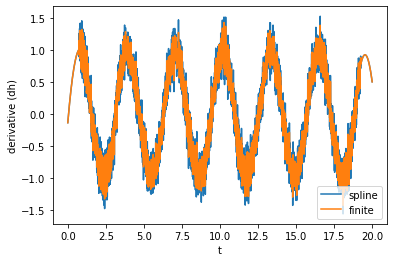

In [9]:
gw_spline_der = gw.spline_differentiated()
gw_numer_der = gw.differentiated()

plot(gw_spline_der, label='spline')
plot(gw_numer_der, lab1="derivative (dh)", label='finite')
plt.legend()

Clearly, derivatives will be noisier than the actual data, so often it is convenient to smooth them out as shown before.

TimeSeries support complex signals. Now, we will create one using `gw` itself. We will copy `gw`, time-shift it, find the common time interval with the original `gw`, and use that as a the imaginary part.

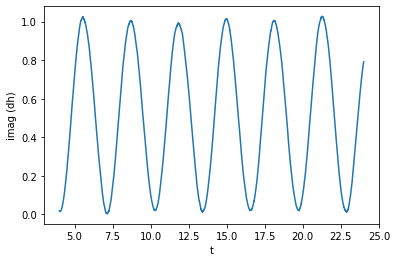

In [10]:
gw_imag = gw.copy()  # It is important to deep copy the object
gw_imag.time_shift(4)

plot(gw_imag, lab1 ="imag (dh)")

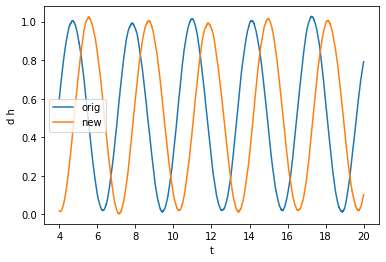

In [11]:
gw, gw_imag = series.sample_common([gw, gw_imag], resample=True)  # Resampling to common times

plot(gw, label="orig")
plot(gw_imag, label="new")
plt.legend()

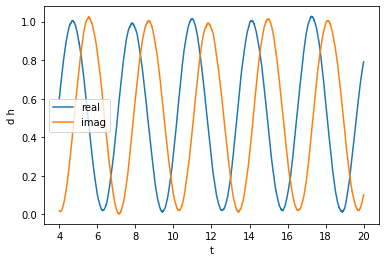

In [12]:
gw_complex = ts.TimeSeries(gw.t, gw.y + 1j * gw_imag.y)

plot(gw_complex.real(), label="real")
plot(gw_complex.imag(), label="imag")
plt.legend()

We can also compute the phase and absolute value. In particular, we will compute the unfolded phase (no wrapping over $2\pi$)

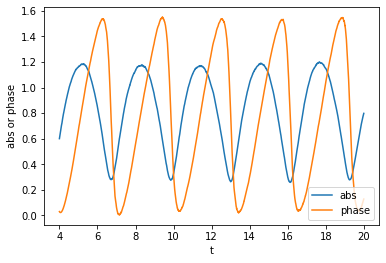

In [13]:
plot(gw_complex.abs(), label='abs')
plot(gw_complex.unfolded_phase(), lab1="abs or phase", label='phase')
plt.legend()

Here, the unfolded phase looks a little bit unusual. This is because we made up the signal.

We can also compute the frequency of the phase, which we can directly smooth.

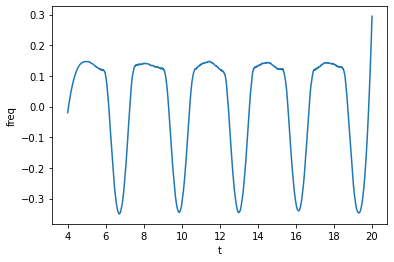

In [14]:
plot(gw_complex.phase_frequency(tsmooth=1.5), lab1="freq")

Next, we will take a Fourier transform. Before, let's pretend that the signal was in geometrized units (as in simulations), and let's make it physical assuming a scale of $M = 1 M_\odot$. For that, use the [unitconv](../unitconv.rst) module. We define a CU object that knows how to convert units.

In [15]:
CU = uc.geom_umass_msun(1) 

# How to convert from geometrized length to physical length?
# Simply multiply times CU.length. Let's check that it is 1.477 km
CU.length  # m

1476.6436994724972

Now we rescale `gw`, assuming that `y` is strain times distance (as usually is). Let's assume a distance of 500 Mpc.

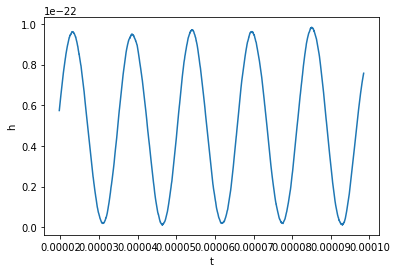

In [16]:
d_Mpc = 500

# inverse = True means from geometrized to physical
gw_physical = gw_complex.time_unit_changed(CU.time, inverse=True)  

gw_physical *= CU.length  # dh -> dh physical
# Now just the strain, since we assume a distance
gw_physical /= (d_Mpc * uc.MEGAPARSEC_SI)

# We have to manually add the redshift
gw_physical.redshifted(luminosity_distance_to_redshift(d_Mpc))

plot(gw_physical.real(), lab1="h")

Okay, now before taking the Fourier transform, we will remove the mean and window our signal. A Tukey window will work.

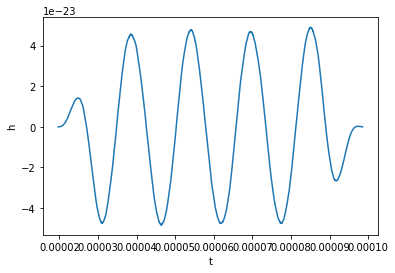

In [17]:
gw_physical.mean_remove()
gw_physical.tukey_window(0.3)
plot(gw_physical.real(), lab1="h")

Finally, we can take the Fourier transform. This is easy to do:

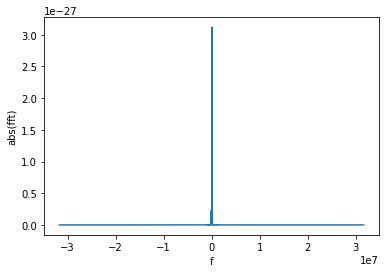

In [18]:
gw_fft = gw_physical.to_FrequencySeries()

# Plotting the amplitude of the Fourier transform
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

The new object is a `FrequencySeries`. It is very similar to a `TimeSeries` and it shares several properties, methods, and features. 

Let's restrict to only positive frequencies close to zero.

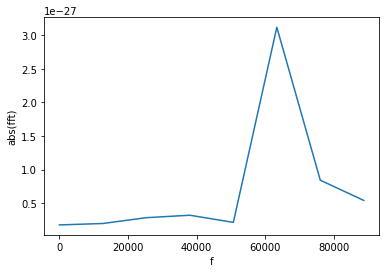

In [19]:
gw_fft.crop(0, 1e5)
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

We can find the frequency of that peak! For this, we find all the peaks with amplitude larger than 1e-27.

Frequency: 64200.69


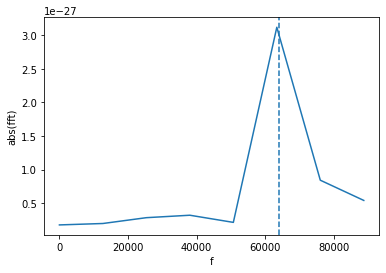

In [20]:
f_peak = gw_fft.peaks_frequencies(1e-27)[0]

print(f"Frequency: {f_peak:.2f}")
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")
plt.axvline(f_peak, ls = 'dashed')

The line is not on the maximum because we use a quadratic interpolation to find a more accurate location of the peak.

Sometimes, it is useful to ignore some data (or example, when we know that the data is invalid). `Series` objects support _masks_ to mark the points we want to ignore. Most functions work transparently with masks: for example, if you ask for the mean of a `Series`, the masked point will be ignored. Other functions do not support masks (most notably, splines). In that case, it is best to completely remove the masked points and work with clean data.

In [21]:
# Let's mask all the point in the spectrum with value larger than 1e-27

spectrum = gw_fft.abs()

print(f"Maximum without mask {spectrum.max():.3e}")

# Apply mask
spectrum.mask_greater(1e-27)

print(f"Maximum with mask {spectrum.max():.3e}")

print(f"Length with mask {len(spectrum)}")

# Remove points
spectrum.mask_remove()

print(f"Length after having removed the masked points {len(spectrum)}")

Maximum without mask 3.119e-27
Maximum with mask 8.423e-28
Length with mask 8
Length after having removed the masked points 7
